In [1]:
# download these files from their original access point at the bottom of 
# the CSCS webpage (https://casch.org/cscs) or the course github and access them locally
# "https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/var_names.csv"
# "https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv"

import pandas as pd
cols = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/var_names.csv")
data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv",
                   na_values=["9999", "", " ", "Presented but no response", "NA"])
empty = (data.isna().sum()==data.shape[0])
data = data[empty.index[~empty]] # keep non empty columns only

/tmp/ipykernel_337/1519420657.py:8: DtypeWarning: Columns (129,408,630,671,689,978,1001,1002,1006,1007,1008,1080,1113,1115,1116,1117,1118,1119,1120,1121,1124,1125,1126,1127,1128,1213,1214,1215,1216,1217,1218,1263,1266,1342,1343,1344,1345,1346,1347,1348,1349,1390,1391,1393,1439,1442,1463,1546,1549,1552,1555,1558,1561) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("https://raw.githubusercontent.com/pointOfive/stat130chat130/main/CP/CSCS_data_anon.csv",


In [2]:
data.shape # This variable indicates the dataset that the observation belongs to
data.DATASET.value_counts()

# This variable indicates the year the observation was recruited
data.SURVEY_collection_year.value_counts()

# This variable indicates whether the observation was part of the cohort survey or the cross-sectional survey 
data.SURVEY_collection_type.value_counts()

# This variable indicates whether the observation is from a cohort participant
data.SURVEY_cohort_participant.value_counts()

# This variable indicates the number of observations the participant has
data.SURVEY_num_responses.value_counts()

# This variable indicates the unique ID of the participant
data.SURVEY_random_id.notna().value_counts() # few have IDs

# This variable indicates cases we recommend removing from an analysis due to fast completion times or possible fraudulent responses.
data.REMOVE_case.value_counts()

# Let's just keep the recommended data
dataV2 = data[data.REMOVE_case=='No'].copy()
dataV2.shape

# And select out participants who are part of the cohort data 
# (but may also be a part of the cross-sectional data)
dataV2_cohort = dataV2[dataV2.SURVEY_cohort_participant].copy()
dataV2_cohort.shape

# And remove year 2023 for which there's not yet much data collected
dataV2_cohortV2 = dataV2_cohort[dataV2_cohort.SURVEY_collection_year!=2023].copy()
dataV2_cohortV2.shape

# And remove columns that have less than some number of missing values
# We could consider no missing values using 850, or...?
missingness_limit = 100 # this retains 166 of 1024 columns that aren't fully empty
columns2keep = dataV2_cohortV2.isna().sum() < missingness_limit
columns2keep = columns2keep.index[columns2keep]
dataV2_cohortV3 = dataV2_cohortV2[columns2keep].copy()
dataV2_cohortV3.shape

# The data itself then looks like this
pd.set_option('display.max_columns', dataV2_cohortV3.shape[1]) # Can cause jupyter notebooks to crash
# DO NOT USE in conjuection with pd.set_option('display.max_rows', 1000) 
dataV2_cohortV3

# Here's a high level summary of the data
for col in dataV2_cohortV3.columns:
    col_summary = dataV2_cohortV3[col].value_counts(dropna=False)
    if len(col_summary)<11:
        print(col_summary, "\n")
    else:
        print(col, dataV2_cohortV3[col].shape, "\n")

# And here are some explanations about the columns in the data
cols_dataV2_cohortV3 = cols.new_var.apply(lambda x: x in dataV2_cohortV3.columns)
cols_dataV2_cohortV3 = cols[cols_dataV2_cohortV3].iloc[:,-2:].drop_duplicates()
for i,row in cols_dataV2_cohortV3.sort_values('new_var').iterrows():
    print("\033[1m\033[4m",row.new_var, "\033[0m", sep="", end=": ")
    print(row.text, end="\n\n")

UNIQUE_id (850,) 

UNIQUE_num_records
3    628
2    199
4     23
Name: count, dtype: int64 

ELIGIBLE_consent
Yes    850
Name: count, dtype: int64 

COVID_prevention_distancing
Very closely        431
Somewhat closely    303
Not at all           75
NaN                  41
Name: count, dtype: int64 

COVID_prevention_masks
Very closely        576
Somewhat closely    142
Not at all           90
NaN                  42
Name: count, dtype: int64 

COVID_prevention_hand_washing
Very closely        581
Somewhat closely    189
NaN                  41
Not at all           39
Name: count, dtype: int64 

COVID_prevention_reduce_people
Very closely        504
Somewhat closely    205
Not at all           96
NaN                  45
Name: count, dtype: int64 

COVID_prevention_avoid_trips
Very closely        410
Somewhat closely    247
Not at all          151
NaN                  42
Name: count, dtype: int64 

COVID_prevention_household
Very closely        387
Somewhat closely    260
Not at all     

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Clean and filter data to remove unwanted rows or missing data
# Drop rows where any of the specified columns have NaN values
data_clean = data.dropna(subset=[
    'DEMO_gender', 
    'WELLNESS_self_rated_physical_health', 
    'WELLNESS_self_rated_mental_health', 
    'WELLNESS_subjective_happiness_scale_happy', 
    'WELLNESS_subjective_happiness_scale_peers'
])

# Verify the missing data count after removal
print("Missing values after dropping NaN in specified columns:")
print(data_clean[['DEMO_gender', 
                             'WELLNESS_self_rated_physical_health', 
                             'WELLNESS_self_rated_mental_health', 
                             'WELLNESS_subjective_happiness_scale_happy', 
                             'WELLNESS_subjective_happiness_scale_peers']].isnull().sum())

# Check the shape of the cleaned dataset
print(f"Shape of the data after dropping rows with NaN in specified columns: {data_clean.shape}")

Missing values after dropping NaN in specified columns:
DEMO_gender                                  0
WELLNESS_self_rated_physical_health          0
WELLNESS_self_rated_mental_health            0
WELLNESS_subjective_happiness_scale_happy    0
WELLNESS_subjective_happiness_scale_peers    0
dtype: int64
Shape of the data after dropping rows with NaN in specified columns: (2803, 1779)


In [4]:
# Data Summarization: Summary statistics for wellness measures by gender
wellness_columns = ['WELLNESS_self_rated_physical_health', 'WELLNESS_self_rated_mental_health', 
                    'WELLNESS_subjective_happiness_scale_happy', 'WELLNESS_subjective_happiness_scale_peers']

# For each wellness measure, calculate mean, median, std by gender
wellness_summary = data_clean.groupby('DEMO_gender')[wellness_columns].describe()
print("\nWellness Summary by Gender:\n", wellness_summary)


Wellness Summary by Gender:
             WELLNESS_self_rated_physical_health                         \
                                          count unique        top freq   
DEMO_gender                                                              
Man                                        1295      5  Very good  491   
Non-binary                                   60      5       Good   17   
Woman                                      1448      5       Good  492   

            WELLNESS_self_rated_mental_health                         \
                                        count unique        top freq   
DEMO_gender                                                            
Man                                      1295      5  Very good  469   
Non-binary                                 60      5  Very good   19   
Woman                                    1448      5  Very good  436   

            WELLNESS_subjective_happiness_scale_happy                  \
                   

In [5]:
# For each wellness measure, calculate mean, median, std by gender
wellness_summary = data_clean.groupby('DEMO_gender')[wellness_columns].describe()
print("\nWellness Summary by Gender:\n", wellness_summary)


Wellness Summary by Gender:
             WELLNESS_self_rated_physical_health                         \
                                          count unique        top freq   
DEMO_gender                                                              
Man                                        1295      5  Very good  491   
Non-binary                                   60      5       Good   17   
Woman                                      1448      5       Good  492   

            WELLNESS_self_rated_mental_health                         \
                                        count unique        top freq   
DEMO_gender                                                            
Man                                      1295      5  Very good  469   
Non-binary                                 60      5  Very good   19   
Woman                                    1448      5  Very good  436   

            WELLNESS_subjective_happiness_scale_happy                  \
                   

In [6]:
print(data_clean['WELLNESS_self_rated_physical_health'].value_counts(dropna=False))

WELLNESS_self_rated_physical_health
Very good    961
Good         936
Excellent    403
Fair         371
Poor         132
Name: count, dtype: int64


In [7]:
# Check unique values in both columns
print("Unique values in DEMO_gender:", data_clean['DEMO_gender'].unique())
print("Unique values in WELLNESS_self_rated_physical_health:", 
      data_clean['WELLNESS_self_rated_physical_health'].unique())

Unique values in DEMO_gender: ['Man' 'Woman' 'Non-binary']
Unique values in WELLNESS_self_rated_physical_health: ['Very good' 'Poor' 'Good' 'Excellent' 'Fair']


In [8]:
# Define the correct order of categories
order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']

# Filter data to only include rows with valid categories in WELLNESS_self_rated_physical_health
data_filtered = data_clean[data_clean['WELLNESS_self_rated_physical_health'].isin(order)]

# Verify the filtered data
print(data_filtered['WELLNESS_self_rated_physical_health'].unique())

['Very good' 'Poor' 'Good' 'Excellent' 'Fair']


In [9]:
# Check for NaNs in both columns
print("NaN count in DEMO_gender:", data_filtered['DEMO_gender'].isna().sum())
print("NaN count in WELLNESS_self_rated_physical_health:", data_filtered['WELLNESS_self_rated_physical_health'].isna().sum())

NaN count in DEMO_gender: 0
NaN count in WELLNESS_self_rated_physical_health: 0


In [10]:
# Check how the data is distributed across gender and wellness categories
print(data_clean.groupby(['DEMO_gender', 'WELLNESS_self_rated_physical_health']).size())
print(data_clean.groupby(['DEMO_gender', 'WELLNESS_self_rated_mental_health']).size())

DEMO_gender  WELLNESS_self_rated_physical_health
Man          Excellent                              209
             Fair                                   132
             Good                                   427
             Poor                                    36
             Very good                              491
Non-binary   Excellent                                7
             Fair                                    14
             Good                                    17
             Poor                                     6
             Very good                               16
Woman        Excellent                              187
             Fair                                   225
             Good                                   492
             Poor                                    90
             Very good                              454
dtype: int64
DEMO_gender  WELLNESS_self_rated_mental_health
Man          Excellent                            2

In [11]:
# Define the correct order of categories
order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']

# Ensure that both 'WELLNESS_self_rated_physical_health' and 'WELLNESS_self_rated_mental_health' are categorical with the correct order
data_clean['WELLNESS_self_rated_physical_health'] = pd.Categorical(
    data_clean['WELLNESS_self_rated_physical_health'], categories=order, ordered=True)

data_clean['WELLNESS_self_rated_mental_health'] = pd.Categorical(
    data_clean['WELLNESS_self_rated_mental_health'], categories=order, ordered=True)

/tmp/ipykernel_337/3664235673.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['WELLNESS_self_rated_physical_health'] = pd.Categorical(
/tmp/ipykernel_337/3664235673.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['WELLNESS_self_rated_mental_health'] = pd.Categorical(


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'DEMO_gender' is treated as a categorical variable with the correct order
data_clean['DEMO_gender'] = pd.Categorical(data_clean['DEMO_gender'], categories=['Man', 'Woman', 'Non-binary'], ordered=False)

/tmp/ipykernel_337/2624750020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['DEMO_gender'] = pd.Categorical(data_clean['DEMO_gender'], categories=['Man', 'Woman', 'Non-binary'], ordered=False)


In [13]:
print(data_clean['WELLNESS_self_rated_physical_health'].unique())
print(data_clean['WELLNESS_self_rated_mental_health'].unique())

['Very good', 'Poor', 'Good', 'Excellent', 'Fair']
Categories (5, object): ['Poor' < 'Fair' < 'Good' < 'Very good' < 'Excellent']
['Very good', 'Poor', 'Fair', 'Good', 'Excellent']
Categories (5, object): ['Poor' < 'Fair' < 'Good' < 'Very good' < 'Excellent']


In [14]:
# Check for any empty combinations of DEMO_gender and wellness ratings
physical_health_counts = data_clean.groupby(['DEMO_gender', 'WELLNESS_self_rated_physical_health']).size()
mental_health_counts = data_clean.groupby(['DEMO_gender', 'WELLNESS_self_rated_mental_health']).size()

print(physical_health_counts)
print(mental_health_counts)

DEMO_gender  WELLNESS_self_rated_physical_health
Man          Poor                                    36
             Fair                                   132
             Good                                   427
             Very good                              491
             Excellent                              209
Woman        Poor                                    90
             Fair                                   225
             Good                                   492
             Very good                              454
             Excellent                              187
Non-binary   Poor                                     6
             Fair                                    14
             Good                                    17
             Very good                               16
             Excellent                                7
dtype: int64
DEMO_gender  WELLNESS_self_rated_mental_health
Man          Poor                                  

/tmp/ipykernel_337/1170485269.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  physical_health_counts = data_clean.groupby(['DEMO_gender', 'WELLNESS_self_rated_physical_health']).size()
/tmp/ipykernel_337/1170485269.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mental_health_counts = data_clean.groupby(['DEMO_gender', 'WELLNESS_self_rated_mental_health']).size()


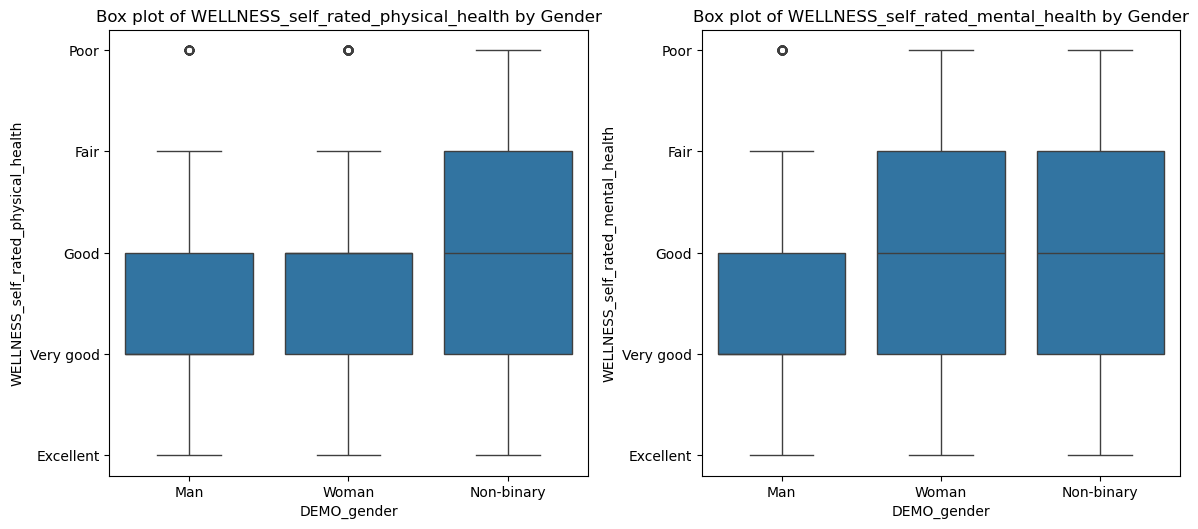

In [15]:
# Ensure 'DEMO_gender' is treated as a categorical variable with the correct order using .loc
data_clean.loc[:, 'DEMO_gender'] = pd.Categorical(data_clean['DEMO_gender'], categories=['Man', 'Woman', 'Non-binary'], ordered=False)

# Drop NaN values from the wellness columns for the plot
data_plot = data_clean.dropna(subset=['WELLNESS_self_rated_physical_health', 'WELLNESS_self_rated_mental_health'])

# Plot the boxplots
plt.figure(figsize=(12, 10))

for i, col in enumerate(['WELLNESS_self_rated_physical_health', 'WELLNESS_self_rated_mental_health'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=data_plot, x='DEMO_gender', y=col)
    plt.title(f'Box plot of {col} by Gender')

plt.tight_layout()
plt.show()

In [16]:
# Define the correct order for the happiness scale
happiness_order = [
    '1 - Not a happy person',
    '2', 
    '3', 
    '4', 
    '5', 
    '6', 
    '7 - A very happy person'
]

# Mapping to convert all values to numeric scale
happiness_mapping = {
    '1 - Less happy': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7 - More happy': 7
}

# Apply the mapping to the column
data_clean['WELLNESS_subjective_happiness_scale_peers'] = data_clean['WELLNESS_subjective_happiness_scale_peers'].map(happiness_mapping)

/tmp/ipykernel_337/3151209392.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['WELLNESS_subjective_happiness_scale_peers'] = data_clean['WELLNESS_subjective_happiness_scale_peers'].map(happiness_mapping)


In [17]:
# Convert the wellness columns to ordered categorical variables
for col in ['WELLNESS_subjective_happiness_scale_happy']:
    data_clean[col] = pd.Categorical(data_clean[col], categories=happiness_order, ordered=True)

/tmp/ipykernel_337/4247650467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[col] = pd.Categorical(data_clean[col], categories=happiness_order, ordered=True)


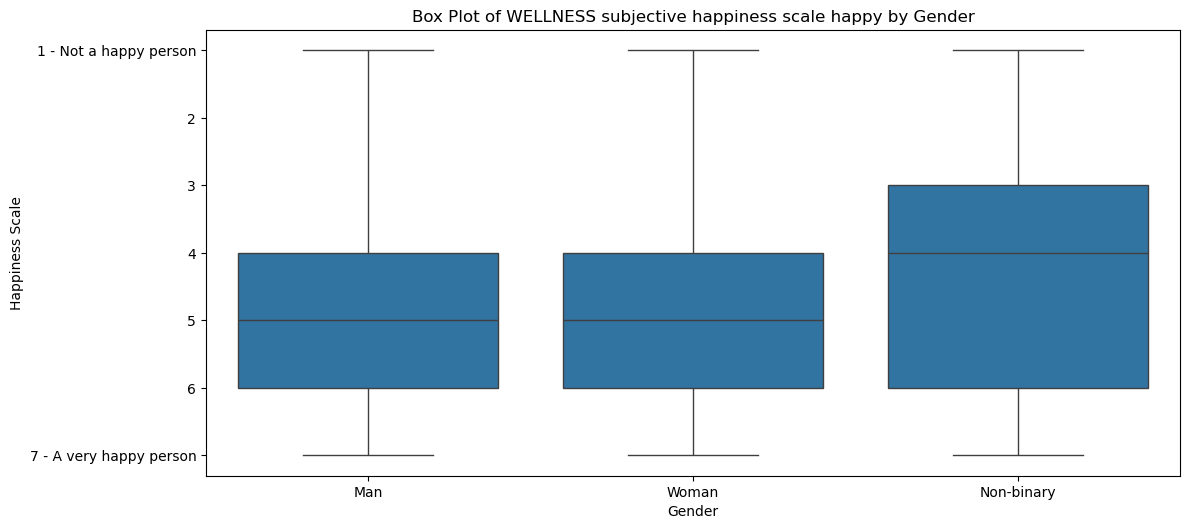

In [18]:
# Data Visualization: Box plots to visualize wellness measures by gender
plt.figure(figsize=(12, 10))
for i, col in enumerate(['WELLNESS_subjective_happiness_scale_happy'], 1):
    plt.subplot(2, 1, i)
    sns.boxplot(data=data_clean, x='DEMO_gender', y=col)
    plt.title(f'Box Plot of {col.replace("_", " ")} by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Happiness Scale')
plt.tight_layout()
plt.show()

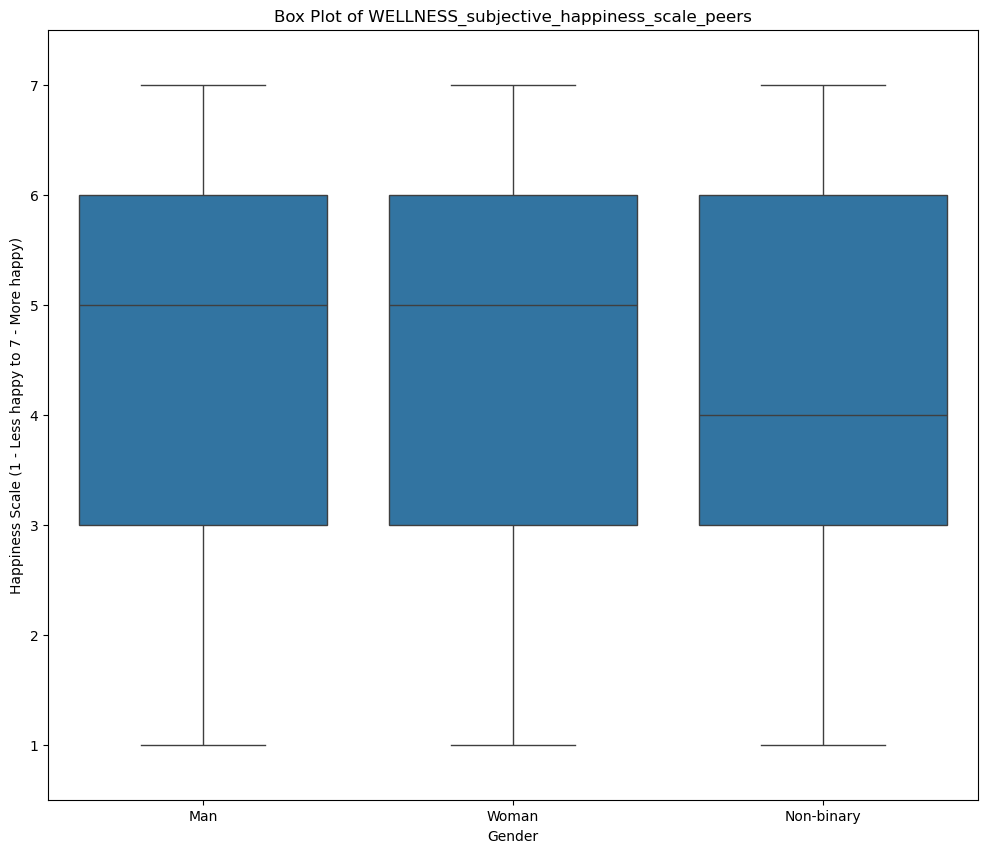

In [19]:
# Data Visualization: Box plot
plt.figure(figsize=(12, 10))
sns.boxplot(data=data_clean, x='DEMO_gender', y='WELLNESS_subjective_happiness_scale_peers')
plt.title('Box Plot of WELLNESS_subjective_happiness_scale_peers')
plt.xlabel('Gender')
plt.ylabel('Happiness Scale (1 - Less happy to 7 - More happy)')
plt.ylim(0.5, 7.5)  # Ensure the y-axis includes the full scale
plt.show()

/tmp/ipykernel_337/1880731424.py:7: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.countplot(data=data_clean, x='DEMO_gender', hue=col, palette=palette)
/tmp/ipykernel_337/1880731424.py:7: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.countplot(data=data_clean, x='DEMO_gender', hue=col, palette=palette)


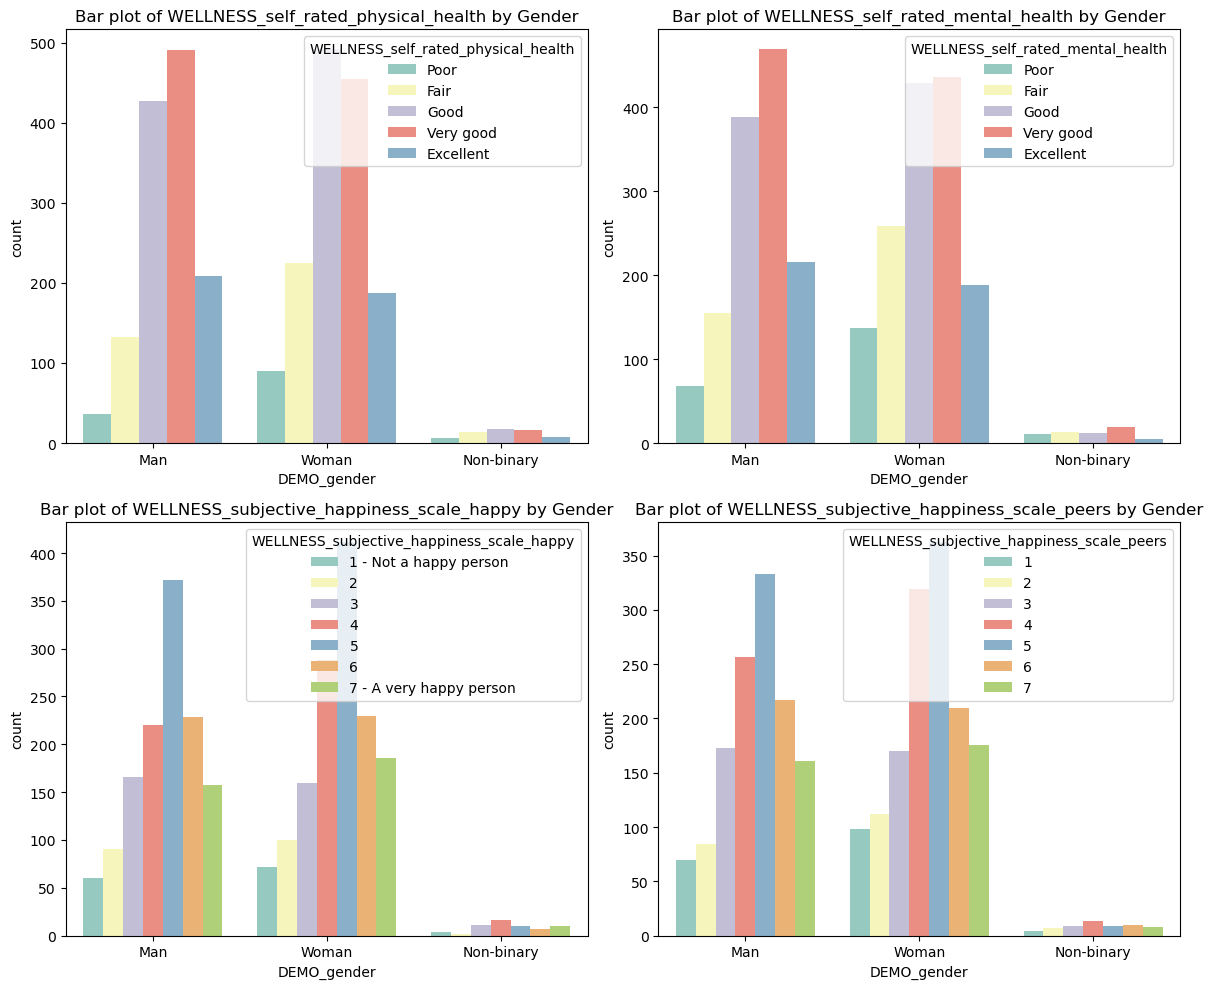

In [20]:
# Data Visualization: Bar plots for categorical wellness measures by gender
palette = sns.color_palette("Set3", n_colors=len(data_clean['WELLNESS_subjective_happiness_scale_peers'].unique()))

plt.figure(figsize=(12, 10))
for i, col in enumerate(wellness_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=data_clean, x='DEMO_gender', hue=col, palette=palette)
    plt.title(f'Bar plot of {col} by Gender')
plt.tight_layout()
plt.show()

In [41]:
# Ensure all necessary libraries are imported
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data for illustration (replace with your actual dataset)
data = pd.DataFrame({
    'DEMO_gender': ['Man', 'Woman', 'Non-binary', 'Man', 'Woman', 'Non-binary'] * 25,
    'WELLNESS_self_rated_physical_health': np.random.choice(['Poor', 'Fair', 'Good', 'Very good', 'Excellent'], 150),
    'WELLNESS_self_rated_mental_health': np.random.choice(['Poor', 'Fair', 'Good', 'Very good', 'Excellent'], 150),
    'WELLNESS_subjective_happiness_scale_happy': np.random.randint(1, 7, 150),
    'WELLNESS_subjective_happiness_scale_peers': np.random.randint(1, 7, 150),
})

# Map ordinal variables to numeric values for analysis
ordinal_mapping = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Very good': 4, 'Excellent': 5}
data['WELLNESS_self_rated_physical_health'] = data['WELLNESS_self_rated_physical_health'].map(ordinal_mapping)
data['WELLNESS_self_rated_mental_health'] = data['WELLNESS_self_rated_mental_health'].map(ordinal_mapping)

# Clean the dataset: drop missing values for the columns we analyze
data_clean = data.dropna(subset=[
    'DEMO_gender',
    'WELLNESS_self_rated_physical_health',
    'WELLNESS_self_rated_mental_health',
    'WELLNESS_subjective_happiness_scale_happy',
    'WELLNESS_subjective_happiness_scale_peers'
])

In [48]:
def bootstrap_mean_diff(data, group_col, value_col, n_bootstrap=1000):
    # Get the unique groups
    unique_groups = data[group_col].unique()

    # Ensure there are 3 groups
    if len(unique_groups) != 3:
        raise ValueError(f"Expected 3 unique groups in '{group_col}', but found {len(unique_groups)}")

    mean_diffs = {}
    ci_dict = {}

    # Loop over each pair of groups
    for i in range(len(unique_groups)):
        for j in range(i + 1, len(unique_groups)):
            group1 = data[data[group_col] == unique_groups[i]][value_col].dropna().to_numpy()
            group2 = data[data[group_col] == unique_groups[j]][value_col].dropna().to_numpy()

            # Check if group1 and group2 are numeric arrays
            if not np.issubdtype(group1.dtype, np.number) or not np.issubdtype(group2.dtype, np.number):
                raise TypeError(f"Data in groups '{unique_groups[i]}' or '{unique_groups[j]}' is not numeric.")

            # Perform bootstrapping to calculate the mean difference
            boot_mean_diffs = []
            for _ in range(n_bootstrap):
                sample1 = np.random.choice(group1, size=len(group1), replace=True)
                sample2 = np.random.choice(group2, size=len(group2), replace=True)
                boot_mean_diffs.append(np.mean(sample1) - np.mean(sample2))

            # Store the results for this pair
            mean_diffs[f'{unique_groups[i]} vs {unique_groups[j]}'] = boot_mean_diffs
            ci_dict[f'{unique_groups[i]} vs {unique_groups[j]}'] = np.percentile(boot_mean_diffs, [2.5, 97.5])

    return mean_diffs, ci_dict

<Figure size 1000x600 with 0 Axes>

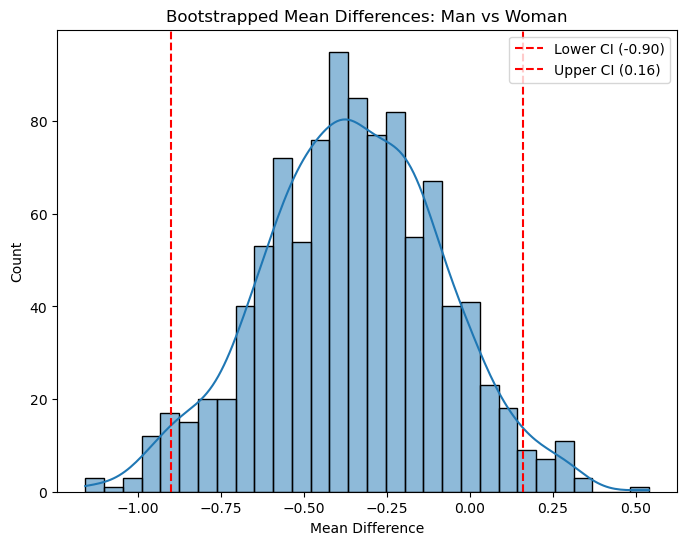

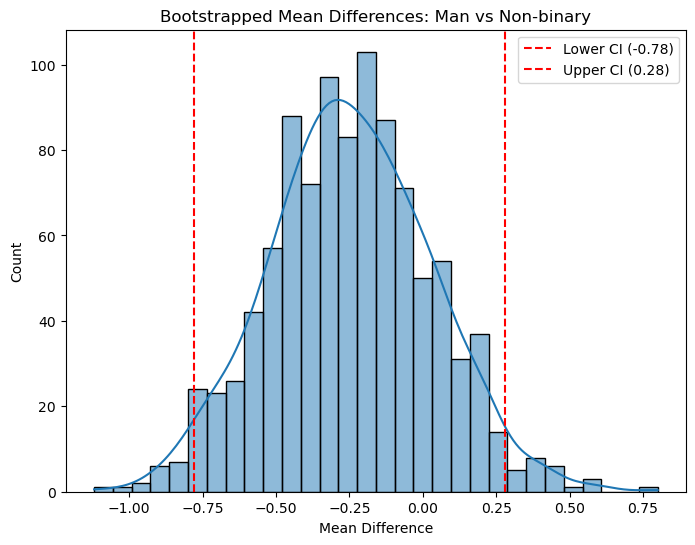

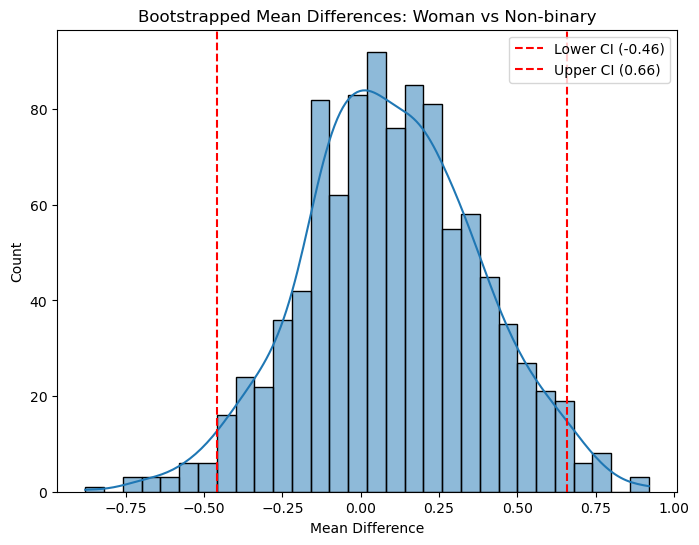

In [59]:
# Call the bootstrapping function for the three groups
mean_diffs_physical, ci_physical = bootstrap_mean_diff(
    data_clean, 'DEMO_gender', 'WELLNESS_self_rated_physical_health'
)

# Plot the results for each comparison
plt.figure(figsize=(10, 6))
for pair, mean_diffs in mean_diffs_physical.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(mean_diffs, kde=True, bins=30)
    ci = ci_physical[pair]
    plt.axvline(x=ci[0], color='red', linestyle='--', label=f"Lower CI ({ci[0]:.2f})")
    plt.axvline(x=ci[1], color='red', linestyle='--', label=f"Upper CI ({ci[1]:.2f})")
    plt.title(f"Bootstrapped Mean Differences: {pair}")
    plt.xlabel("Mean Difference")
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

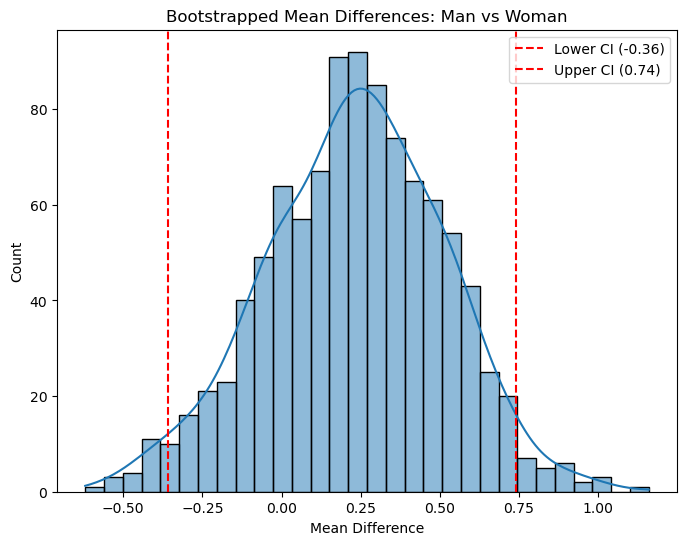

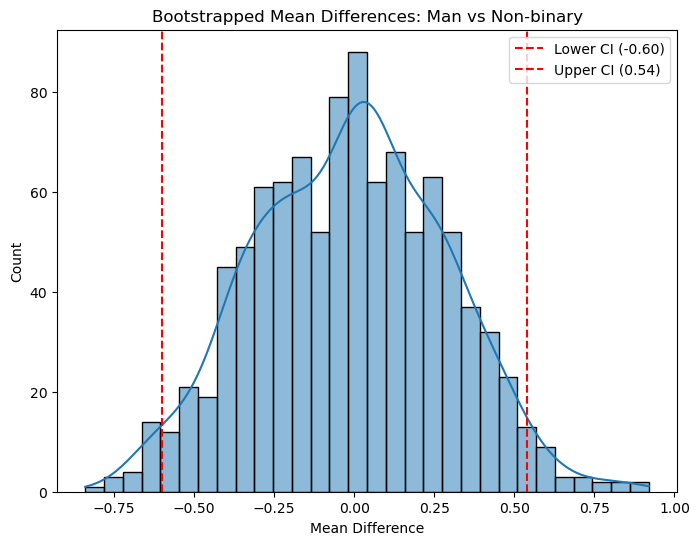

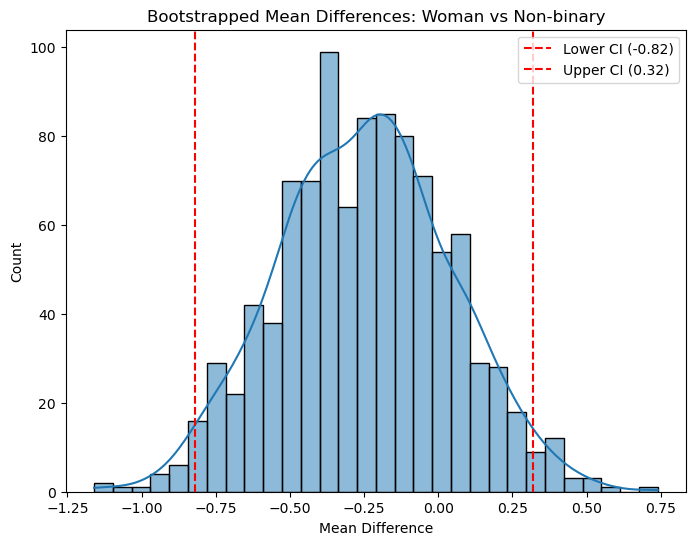

In [50]:
# Call the bootstrapping function for the three groups
mean_diffs_physical, ci_physical = bootstrap_mean_diff(
    data_clean, 'DEMO_gender', 'WELLNESS_self_rated_mental_health'
)

# Plot the results for each comparison
plt.figure(figsize=(10, 6))
for pair, mean_diffs in mean_diffs_physical.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(mean_diffs, kde=True, bins=30)
    ci = ci_physical[pair]
    plt.axvline(x=ci[0], color='red', linestyle='--', label=f"Lower CI ({ci[0]:.2f})")
    plt.axvline(x=ci[1], color='red', linestyle='--', label=f"Upper CI ({ci[1]:.2f})")
    plt.title(f"Bootstrapped Mean Differences: {pair}")
    plt.xlabel("Mean Difference")
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

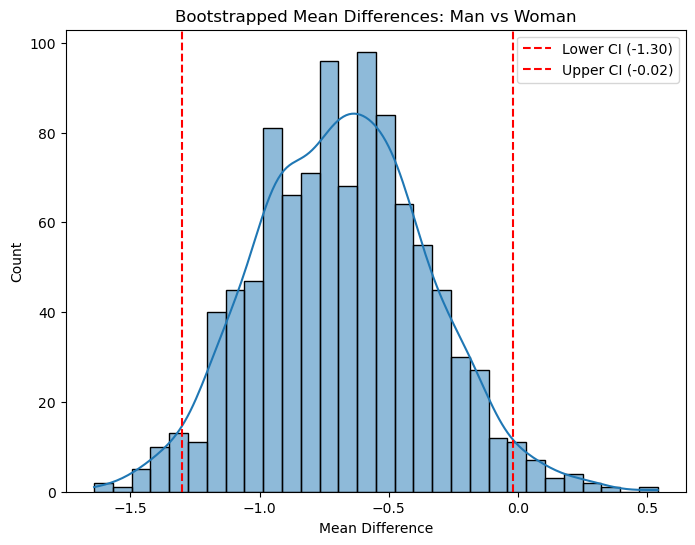

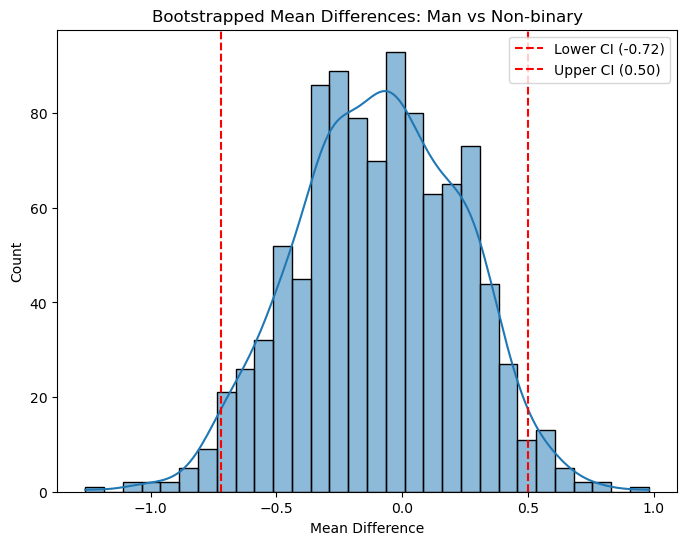

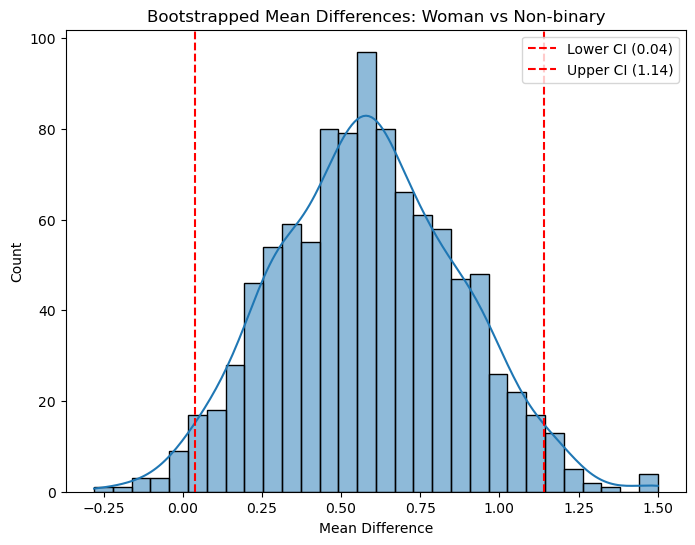

In [53]:
# Call the bootstrapping function for the three groups
mean_diffs_physical, ci_physical = bootstrap_mean_diff(
    data_clean, 'DEMO_gender', 'WELLNESS_subjective_happiness_scale_happy'
)

# Plot the results for each comparison
plt.figure(figsize=(10, 6))
for pair, mean_diffs in mean_diffs_physical.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(mean_diffs, kde=True, bins=30)
    ci = ci_physical[pair]
    plt.axvline(x=ci[0], color='red', linestyle='--', label=f"Lower CI ({ci[0]:.2f})")
    plt.axvline(x=ci[1], color='red', linestyle='--', label=f"Upper CI ({ci[1]:.2f})")
    plt.title(f"Bootstrapped Mean Differences: {pair}")
    plt.xlabel("Mean Difference")
    plt.legend()
    plt.show()

<Figure size 1000x600 with 0 Axes>

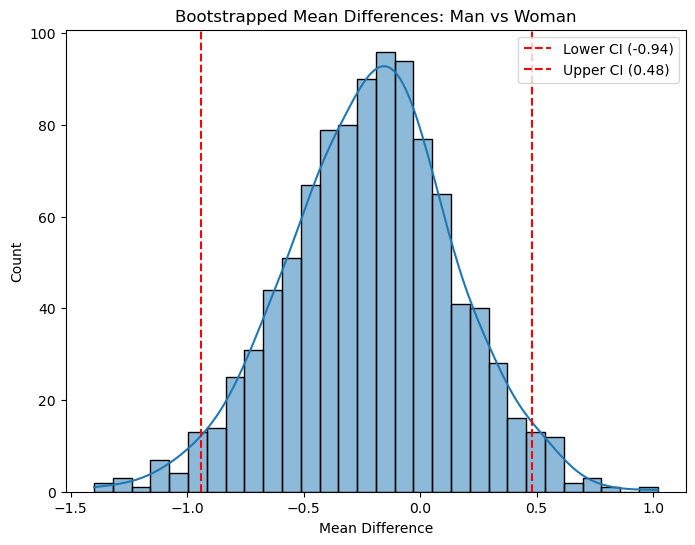

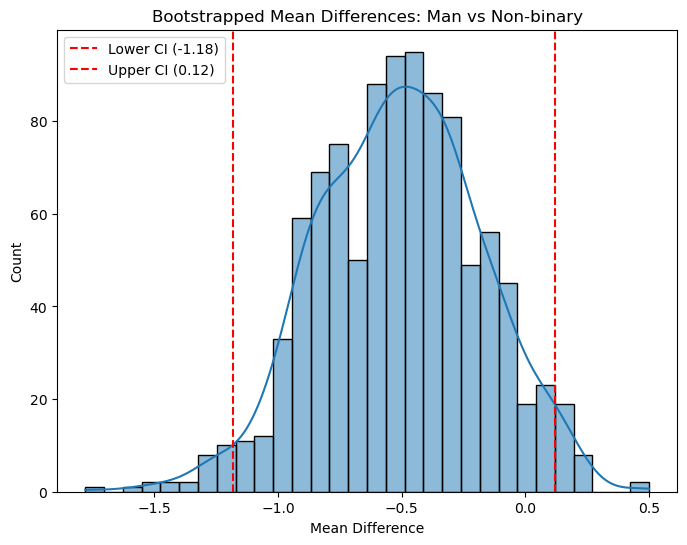

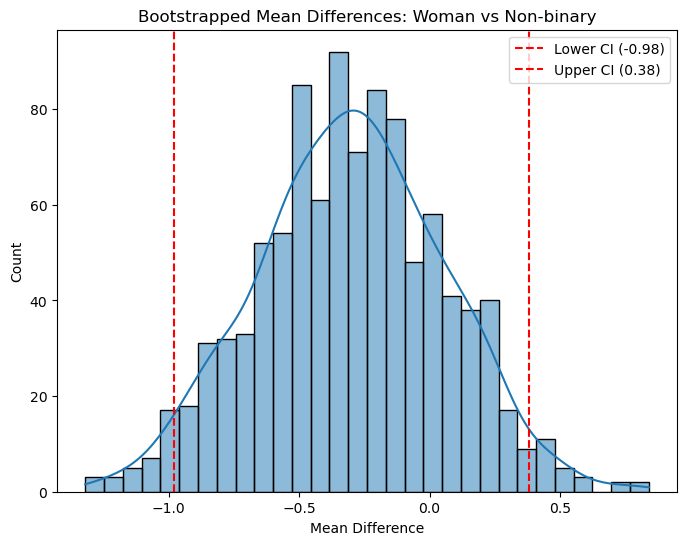

In [54]:
# Call the bootstrapping function for the three groups
mean_diffs_physical, ci_physical = bootstrap_mean_diff(
    data_clean, 'DEMO_gender', 'WELLNESS_subjective_happiness_scale_peers'
)

# Plot the results for each comparison
plt.figure(figsize=(10, 6))
for pair, mean_diffs in mean_diffs_physical.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(mean_diffs, kde=True, bins=30)
    ci = ci_physical[pair]
    plt.axvline(x=ci[0], color='red', linestyle='--', label=f"Lower CI ({ci[0]:.2f})")
    plt.axvline(x=ci[1], color='red', linestyle='--', label=f"Upper CI ({ci[1]:.2f})")
    plt.title(f"Bootstrapped Mean Differences: {pair}")
    plt.xlabel("Mean Difference")
    plt.legend()
    plt.show()